# baseline

- classification baseline code
- Resnet을 이용해, label(0,1,2) 분류
- settings

```
1. random oversampling
2. early stopping
3. kfold (미정)
```


In [1]:
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import torchvision.models as models
import cv2
import albumentations as A

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys
from tqdm import tqdm

import wandb
import albumentations as A


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)


Using Pytorch version :  1.12.1  Device :  cuda


In [2]:
# import early stop

p = os.path.abspath('../../utils') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.

# 데이터 분류

## train / valid / test

In [3]:
#1. train, test 나누기

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

def get_num(file_str):
    return int(file_str.split("\\")[-1].split(".")[0])

test_idx = 0; # idx =0 : normal
# idx =1 : train size : 


X_images = glob('../../data/bmc_label_voc/JPEGImages/*.jpg')
X_train, X_valid = train_test_split(X_images, test_size=0.2,random_state=1004)

if test_idx ==0:
    pass
elif test_idx == 1:
    # 20%
    X_train=X_train[:int(len(X_train)*0.2)]
elif test_idx == 2:
    # 40%
    X_train=X_train[:int(len(X_train)*0.4)]
elif test_idx == 3:
    # 60%
    X_train=X_train[:int(len(X_train)*0.6)]
elif test_idx == 4:
    # 80%
    X_train=X_train[:int(len(X_train)*0.8)]


X_train_name=list(map(get_num,X_train))
X_valid_name=list(map(get_num,X_valid))

#첫번째 열 이름 바꿔주기
label_df = pd.read_csv('../../bmc.csv')
column_names = list(label_df.columns)
column_names[0]='file_name'
label_df.columns = column_names

# Y값 찾아오기
Y_train_df=pd.merge(pd.DataFrame(X_train_name,columns=['file_name']),label_df,left_on='file_name',right_on='file_name',how='inner')
Y_valid_df=pd.merge(pd.DataFrame(X_valid_name,columns=['file_name']),label_df,left_on='file_name',right_on='file_name',how='inner')



print("---")
print("훈련 셋 : ",len(Y_train_df),Counter(Y_train_df['label']))
print("검증 셋 : ",len(Y_valid_df),Counter(Y_valid_df['label']))
print("---")


---
훈련 셋 :  866 Counter({2: 335, 0: 313, 1: 218})
검증 셋 :  217 Counter({0: 83, 2: 81, 1: 53})
---


In [4]:
len(X_train_name)

866

In [25]:
label_df

,file_name,origin_name,color,residue,turbidity,label
0,0,1301837407-1,0,0,0,0
1,1,1411450810-1,0,0,0,0
2,2,1651193832-1,0,0,0,0
3,3,2077897036-1,0,0,0,0
4,4,290980310-1,0,1,0,0
...,...,...,...,...,...,...
1078,1078,PANO_20200407_221523,2,2,1,2
1079,1079,PANO_20200407_221527,2,2,1,2
1080,1080,PANO_20200818_174909,2,2,1,2
1081,1081,PANO_20210330_062718,2,2,1,2


In [27]:
print("color : ",Counter(label_df['color']))
print("residue : ",Counter(label_df['residue']))
print("turbidity : ",Counter(label_df['turbidity']))


color :  Counter({2: 751, 0: 175, 1: 157})
residue :  Counter({2: 530, 1: 320, 0: 233})
turbidity :  Counter({1: 630, 0: 453})


In [6]:
len(set(label_df['color']))

3

## random over sampling

# 데이터 정의

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader



class BowelDataset(Dataset):
    def __init__(self, data_path_list,label_df,to_tensor,transform,torch_augment=None,album_augment=None):
        self.data_path_list = data_path_list
        self.label_df = label_df
        self.to_tensor = to_tensor
        self.transform = transform
        
        self.torch_augment = torch_augment
        self.album_augment = album_augment
        

    def __len__(self):
        return len(self.data_path_list)

    def __getitem__(self, idx):
        file_path = self.data_path_list[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.album_augment:
            augmented=self.album_augment(image=image)
            image=augmented['image']
        image = self.to_tensor(image)
        if self.torch_augment:
            image=self.torch_augment(image)

        if self.transform:
            #1. 이미지 사이즈 변환
            image=self.transform(image).type(torch.float32)# 이미지 0~1 정규화
        return image, torch.tensor(self.label_df.iloc[idx]['label'])
        
        

In [8]:

#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 16개 이미지
EPOCHS = 50 # 전체 데이터 셋을 50번 반복
lr=1e-4

In [9]:
flare_roi=(0, 0, 1, 0.5) # 맺힐 영역
angle_lower=0 #원의 정도
angle_upper=1
num_flare_circles_lower=1 #원의 수
num_flare_circles_upper=2
src_radius=400
src_color=(255, 255, 255)

In [10]:
np.linspace(1, 50, num=50//10)

array([ 1.  , 13.25, 25.5 , 37.75, 50.  ])

In [38]:
import albumentations as A
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.
train_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_train,
                                                       Y_train_df,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
            transforms.RandomErasing(p=0.3,scale=(0.02, 0.2),value=255),

                                                            #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        ),
                                                        #torch_augment =  transforms.Compose([transforms.RandomErasing(p=0.4),]),
                                                        album_augment = A.Compose([
                                                          A.RandomBrightnessContrast(brightness_limit=(-0.2,0.3),p=1),
                                                          A.RandomShadow(shadow_roi=(0,0,1,1),shadow_dimension=6,p=0.4),
                                                            #  A.RandomSunFlare(flare_roi, angle_lower, angle_upper,
                                                            #  num_flare_circles_lower,num_flare_circles_upper,
                                                            #  src_radius,
                                                            #  src_color,
                                                            #  p=0.8)
                                                            ])
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           num_workers=0
                                           ) # 순서가 암기되는것을 막기위해.
                                           
valid_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_valid,
                                                       Y_valid_df,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
                                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        )
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.


test_loader = torch.utils.data.DataLoader(dataset = 
                                           BowelDataset(X_valid,
                                                       Y_valid_df,
                                                       to_tensor = transforms.ToTensor(),
                                                       transform = torch.nn.Sequential(
                                                            transforms.Resize([512,512]),
                                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                        )
                                                      ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,) # 순서가 암기되는것을 막기위해.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train :  torch.Size([32, 3, 512, 512]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor


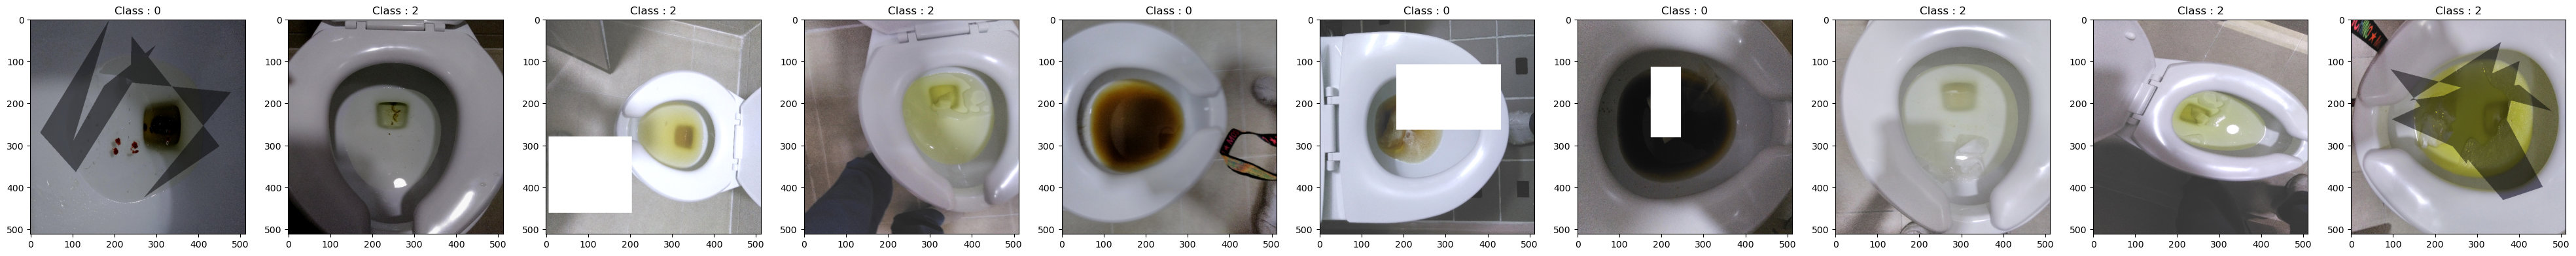

In [39]:

# 4. 데이터 확인하기
for (X_train_sample,Y_train_sample) in train_loader:
    print("X_train : ",X_train_sample.size(),'type:',X_train_sample.type())
    print("Y_train : ",Y_train_sample.size(),'type:',Y_train_sample.type())
    break

pltsize = 1
plt.figure(figsize=(50*pltsize,pltsize*10))#하나당 10,1

for i in range(10):
    plt.subplot(1,10,i+1)
    transposed_img = np.transpose(X_train_sample[i].detach().numpy(),(1,2,0))
    plt.imshow(transposed_img )# 배치에서 10개만 추출
    plt.title('Class : '+str(Y_train_sample[i].item()))

# 모델 설계

- 기본 resnet18

In [63]:
# pretrained

class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1')
        #self.num_ftrs = self.model.fc.out_features
        self.num_ftrs = 512
        self.model.fc = nn.Sequential(
            #nn.BatchNorm1d(self.num_ftrs+self.n_mfcc),                
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,3)
                            )
        

    def forward(self, x):
        x = self.model(x)
        #x  = self.fc(x)
        return x

    
def model_initialize():
    model = ResLayer().cuda()
    return model

In [64]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in tqdm(enumerate(train_loader)):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [65]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [66]:
check_path = './checkpoint/baseline_getlabel_'+'resnet18_change_'+'_512_'+'.pt'
print(check_path)
early_stopping = EarlyStopping(patience = 3, verbose = True, path=check_path)

best_train_acc=0 # accuracy 기록용
best_valid_acc=0

model=model_initialize()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)



print("학습 시작")
for Epoch in range(1,EPOCHS+1):
    train_loss,train_accuracy = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_accuracy = evaluate(model, valid_loader)

    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
          format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))


    early_stopping(valid_loss, model)
    if -early_stopping.best_score == valid_loss:
        best_train_acc, best_valid_acc = train_accuracy,valid_accuracy

    if early_stopping.early_stop:
            #train_accs.append(best_train_acc)
            #valid_accs.append(best_valid_acc)
            #print("[{} 교차검증] Early stopping".format(data_ind))
            break

    if Epoch==EPOCHS:
        #만약 early stop 없이 40 epoch라서 중지 된 경우. 
        pass
        #train_accs.append(best_train_acc)
        #valid_accs.append(best_valid_acc)

./checkpoint/baseline_getlabel_resnet18_change__512_.pt
학습 시작


28it [02:24,  5.16s/it]



[EPOCH:1]	 Train Loss:0.0346	 Train Acc:44.34 %  | 	Valid Loss:0.0298 	Valid Acc: 60.83 %

Validation loss decreased (inf --> 0.029769).  Saving model ...


28it [02:24,  5.14s/it]



[EPOCH:2]	 Train Loss:0.0287	 Train Acc:61.20 %  | 	Valid Loss:0.0253 	Valid Acc: 72.81 %

Validation loss decreased (0.029769 --> 0.025283).  Saving model ...


28it [02:24,  5.18s/it]



[EPOCH:3]	 Train Loss:0.0246	 Train Acc:70.55 %  | 	Valid Loss:0.0230 	Valid Acc: 79.72 %

Validation loss decreased (0.025283 --> 0.022978).  Saving model ...


28it [02:21,  5.05s/it]



[EPOCH:4]	 Train Loss:0.0222	 Train Acc:79.91 %  | 	Valid Loss:0.0229 	Valid Acc: 81.11 %

Validation loss decreased (0.022978 --> 0.022876).  Saving model ...


28it [02:22,  5.10s/it]



[EPOCH:5]	 Train Loss:0.0212	 Train Acc:84.99 %  | 	Valid Loss:0.0204 	Valid Acc: 77.42 %

Validation loss decreased (0.022876 --> 0.020437).  Saving model ...


28it [02:25,  5.20s/it]



[EPOCH:6]	 Train Loss:0.0183	 Train Acc:87.53 %  | 	Valid Loss:0.0204 	Valid Acc: 82.95 %

Validation loss decreased (0.020437 --> 0.020354).  Saving model ...


28it [02:25,  5.18s/it]



[EPOCH:7]	 Train Loss:0.0173	 Train Acc:91.34 %  | 	Valid Loss:0.0195 	Valid Acc: 79.72 %

Validation loss decreased (0.020354 --> 0.019515).  Saving model ...


28it [02:26,  5.24s/it]



[EPOCH:8]	 Train Loss:0.0170	 Train Acc:87.30 %  | 	Valid Loss:0.0201 	Valid Acc: 80.18 %

EarlyStopping counter: 1 out of 3


28it [02:22,  5.08s/it]



[EPOCH:9]	 Train Loss:0.0157	 Train Acc:91.11 %  | 	Valid Loss:0.0200 	Valid Acc: 77.88 %

EarlyStopping counter: 2 out of 3


28it [02:22,  5.10s/it]



[EPOCH:10]	 Train Loss:0.0144	 Train Acc:94.69 %  | 	Valid Loss:0.0176 	Valid Acc: 83.87 %

Validation loss decreased (0.019515 --> 0.017639).  Saving model ...


28it [02:21,  5.07s/it]



[EPOCH:11]	 Train Loss:0.0131	 Train Acc:96.19 %  | 	Valid Loss:0.0186 	Valid Acc: 83.41 %

EarlyStopping counter: 1 out of 3


28it [02:20,  5.03s/it]



[EPOCH:12]	 Train Loss:0.0120	 Train Acc:97.11 %  | 	Valid Loss:0.0167 	Valid Acc: 84.33 %

Validation loss decreased (0.017639 --> 0.016678).  Saving model ...


28it [02:17,  4.92s/it]



[EPOCH:13]	 Train Loss:0.0115	 Train Acc:96.65 %  | 	Valid Loss:0.0168 	Valid Acc: 82.03 %

EarlyStopping counter: 1 out of 3


28it [02:18,  4.93s/it]



[EPOCH:14]	 Train Loss:0.0101	 Train Acc:98.85 %  | 	Valid Loss:0.0166 	Valid Acc: 85.71 %

Validation loss decreased (0.016678 --> 0.016650).  Saving model ...


28it [02:18,  4.94s/it]



[EPOCH:15]	 Train Loss:0.0092	 Train Acc:98.85 %  | 	Valid Loss:0.0175 	Valid Acc: 83.87 %

EarlyStopping counter: 1 out of 3


28it [02:17,  4.91s/it]



[EPOCH:16]	 Train Loss:0.0094	 Train Acc:98.85 %  | 	Valid Loss:0.0151 	Valid Acc: 86.64 %

Validation loss decreased (0.016650 --> 0.015060).  Saving model ...


28it [02:19,  4.97s/it]



[EPOCH:17]	 Train Loss:0.0093	 Train Acc:99.31 %  | 	Valid Loss:0.0140 	Valid Acc: 85.71 %

Validation loss decreased (0.015060 --> 0.014025).  Saving model ...


28it [02:20,  5.02s/it]



[EPOCH:18]	 Train Loss:0.0081	 Train Acc:99.19 %  | 	Valid Loss:0.0143 	Valid Acc: 87.10 %

EarlyStopping counter: 1 out of 3


28it [02:19,  4.99s/it]



[EPOCH:19]	 Train Loss:0.0078	 Train Acc:99.65 %  | 	Valid Loss:0.0157 	Valid Acc: 81.57 %

EarlyStopping counter: 2 out of 3


28it [02:15,  4.85s/it]



[EPOCH:20]	 Train Loss:0.0073	 Train Acc:99.54 %  | 	Valid Loss:0.0144 	Valid Acc: 86.18 %

EarlyStopping counter: 3 out of 3


In [49]:
print("[교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(best_train_acc,best_valid_acc ))

[교차검증] train ACC : 100.0000 |	 valid ACC: 84.3318 


# test

In [50]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []

    #roc-auc score 용
    outputs= []

    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            
            
            answers +=label
            outputs += F.softmax(output,dim=1)
            predictions +=prediction
            
        return predictions,answers,test_loss, outputs

In [51]:
# Confusion matrix (resnet18)
# 모델을 각각 불러와서 test set을 평가한다.

from re import A
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

cf = np.zeros((2,2))

model=model_initialize()
criterion = nn.CrossEntropyLoss()
model.load_state_dict(torch.load('./checkpoint/baseline_getlabel_'+'resnet18'+'_512_'+'.pt'))

predictions,answers,test_loss,outputs = test_evaluate(model, test_loader)
predictions=[ dat.cpu().numpy() for dat in predictions]
answers=[ dat.cpu().numpy() for dat in answers]
outputs=[ dat.cpu().numpy() for dat in outputs]


cf = confusion_matrix(answers, predictions)

#fscroe macro추가
fscore = f1_score(answers,predictions,average='macro')
acc = accuracy_score(answers,predictions)
roc_auc = roc_auc_score(answers,outputs,multi_class='ovr')

print("Accuracy : {:.4f}% ".format(acc*100))
print("f score : {:.4f} ".format(fscore))
print("roc_auc score : {:.4f} ".format(roc_auc))
print(cf)
print("-----")

result_file_idx = 'baseline_test_auc'+str(test_idx)+'.csv'
result_file_name = 'baseline_test_auc'+'.csv'
res_df=pd.DataFrame({'file_name':[result_file_idx,],'Acc':[acc*100,],'fscore':[fscore,],'roc_auc':[roc_auc,]})

res_df.to_csv(result_file_name,index=False,mode='a',header=False)


Accuracy : 84.3318% 
f score : 0.8210 
roc_auc score : 0.9517 
[[79  2  2]
 [11 34  8]
 [ 0 11 70]]
-----
